In [91]:
# from flask import Flask, render_template, request, send_file
from PIL import Image, ImageDraw, ImageOps
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import cv2
import warnings
warnings.filterwarnings("ignore")

In [92]:
image_path = "./images/cat.png" # Change to Relative Path or some hardcoded path on the repo

In [93]:
image = Image.open(image_path)
size = min(image.size)
image = ImageOps.fit(image, (size, size), Image.ANTIALIAS)
width, height = image.size

# Create a circular mask
mask = Image.new('L', image.size, 0)
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, size, size), fill=255)

# Apply circular mask to the image
circular_image = Image.new('RGB', (width, height))
circular_image.paste(image, mask=mask)

# Save or serve the resulting image
output = BytesIO()
output_path = "./out_images/"+ image_path[9:]
circular_image.save(output, format='PNG')
circular_image.save(output_path, format='PNG')

In [94]:
def image_cleanup(img):
    # Maybe Do: Make the contrast more contrasty
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # Scale the image to 400x400 pixels
    scaled_image = cv2.resize(blurred_image, (400, 400))
    return scaled_image

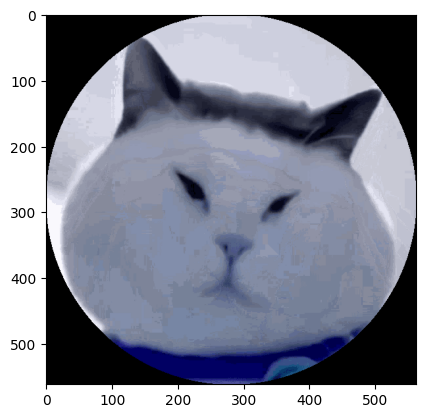

In [95]:
img = cv2.imread(output_path)
plt.imshow(img)

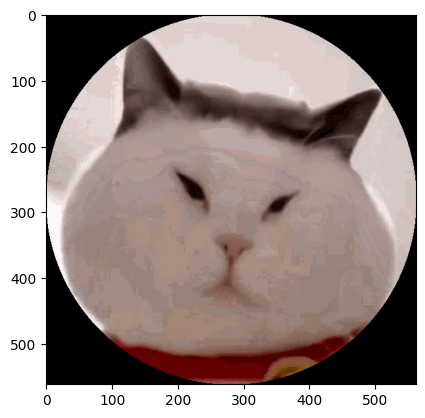

In [96]:
img2 = img[:,:,::-1]
plt.imshow(img2)

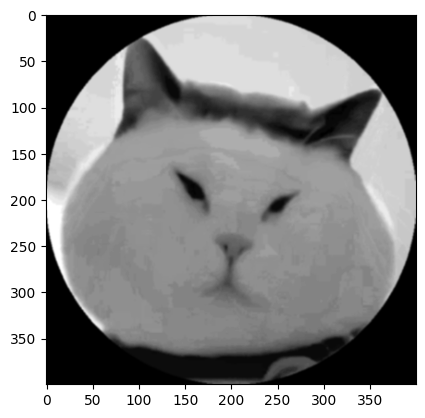

In [97]:
img3 = image_cleanup(img2)
plt.imshow(img3,'gray')

In [98]:
def edge_points(img, n):
    points = []
    height, width = img.shape
    # Define circle parameters (adjust these based on your image size)
    center_x = width // 2
    center_y = height // 2
    radius = min(center_x, center_y) - 1  # Ensure the circle is within the image bounds

    # Sample points along the circumference
    theta = np.linspace(0, 2 * np.pi, n)
    edge_points_x = np.uint16(center_x + radius * np.cos(theta))
    edge_points_y = np.uint16(center_y + radius * np.sin(theta))
    edge_points_x = edge_points_x.astype(np.int64)
    edge_points_y = edge_points_y.astype(np.int64)
    return edge_points_x, edge_points_y

def draw_lines(edge_x, edge_y):
    for i in range(0,100):
        for j in range(i,100):
            xs = [edge_x[i],edge_x[j]]
            ys = [edge_y[i],edge_y[j]]
            plt.plot(xs, ys,color='black',lw = 0.1)

edge_x, edge_y = edge_points(img3, 100)
# plt.figure(figsize=(5,5))
# plt.plot(edge_x, edge_y,'o')
# draw_lines(edge_x, edge_y)

In [99]:
def bresenham(x1, y1, x2, y2, swap=False, neg_y=False):
    if y2 < y1 and not neg_y:
        return bresenham(x1, y1, x2, y2, swap=swap, neg_y=True)
    if x2 < x1:
        return bresenham(x2, y2, x1, y1, swap=swap)[::-1]
    line = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    if dy > dx:
        return bresenham(y1, x1, y2, x2, swap=True)
    P = 2 * dy - dx
    while x <= x2:
        if swap:
            line.append((y, x))
        else:
            line.append((x, y))
        x += 1
        if P < 0:
            P = P + 2 * dy
        else:
            P = P + 2 * dy - 2 * dx
            if neg_y:
                y -= 1
            else:
                y += 1
    return line

# bresenham(29,97,196,1)

In [105]:
def create_database(edge_x,edge_y):
    line_dict = dict()
    for i in range(0,100): # for every edge point
        for j in range(i+3,100): # go to all the others, 
            # Calculate intermediate points with bresenham
            points = [(edge_x[i],edge_y[i]), (edge_x[j],edge_y[j])] 
            points.sort(key=lambda x: x[0])
            x1 = points[0][0]
            y1 = points[0][1]
            x2 = points[1][0]
            y2 = points[1][1]
            line_dict[f"{x1},{y1} {x2},{y2}"] = bresenham(x1,y1,x2,y2) # Add to dictionary
    return line_dict

line_dict = create_database(edge_x,edge_y)
# line_dict['29,97 196,1']

In [106]:
def error(img,canvas):
    return sum(sum(abs(img-canvas)))

def try_line(points,current_canvas,img):
    temp_canvas = current_canvas.copy()
    for x,y in points:
        temp_canvas[x,y] += 51
    return error(img,temp_canvas), temp_canvas

In [118]:
import sys

def pick_next_point(start,current_canvas,img, line_dict):
    best_line = "" # initialise to random edge point ??
    best_error = sys.maxsize # error(img,current_canvas)
    filtered_dict = {key:value for key, value in line_dict.items() if start in key}
    print(filtered_dict.keys())
    print("NEXT")
    for key, value in filtered_dict.items():
        current_error, temp_canvas = try_line(value,current_canvas,img)
        if current_error < best_error:
            best_error = current_error
            best_line = key
            current_canvas = temp_canvas
    for end_point in best_line.split():
        if end_point != start:
            point = end_point
    return end_point, current_canvas

In [108]:
def sim(n, img):
    start = "29,97"
    xs = [29]
    ys = [97]
    current_canvas = np.zeros_like(img)
    for i in range(n):
        point, new_canvas = pick_next_point(start, current_canvas, img, line_dict)
        start = point
        x, y = point.split(',')
        xs.append(int(x))
        ys.append(int(y))
        current_canvas = new_canvas
    return xs,ys

dict_keys(['29,97 399,200', '29,97 398,212', '29,97 397,225', '29,97 395,237', '29,97 392,249', '29,97 389,262', '29,97 384,273', '29,97 379,285', '29,97 373,296', '29,97 367,307', '29,97 360,317', '29,97 352,327', '29,97 344,337', '29,97 335,346', '29,97 325,354', '29,97 315,362', '29,97 304,369', '29,97 293,375', '29,97 282,381', '29,97 271,385', '29,97 259,390', '29,97 246,393', '29,97 234,395', '29,97 222,397', '29,97 209,398', '29,97 196,398', '29,97 184,398', '29,97 171,396', '29,97 159,394', '29,97 146,391', '29,97 134,388', '29,97 123,383', '29,97 111,378', '29,97 100,372', '29,97 89,365', '29,97 79,358', '29,97 69,350', '29,97 60,341', '29,97 51,332', '29,97 43,323', '29,97 36,312', '29,302 29,97', '23,291 29,97', '17,279 29,97', '13,268 29,97', '9,256 29,97', '5,243 29,97', '3,231 29,97', '1,218 29,97', '1,206 29,97', '1,193 29,97', '1,181 29,97', '3,168 29,97', '5,156 29,97', '9,143 29,97', '13,131 29,97', '29,97 51,67', '29,97 60,58', '29,97 69,49', '29,97 79,41', '29,97 89

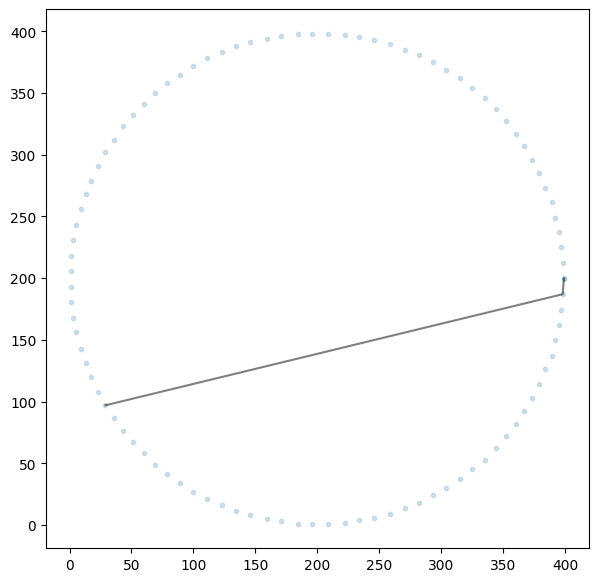

In [119]:
plt.figure(figsize=(7,7))
xs,ys = sim(10, img3)
print(xs,ys)
edge_x, edge_y = edge_points(img3, 100)
plt.plot(edge_x, edge_y,'.',alpha = 0.2)
plt.plot(xs,ys,alpha = 0.5,color='black')